# Text classification with CNNs and LSTMs

In this notebook CNNs and LSTMs are applied for document classification. Here, the documents are IMDB movie reviews. The IMDB Movie Review corpus is a standard dataset for the evaluation of text-classifiers. It consists of 25000 movies reviews from IMDB, labeled by sentiment (positive/negative). 

The main goal of the notebook is to demonstrate how different CNN- and LSTM architectures can be defined, trained and evaluated in tensorflow/keras. Hyperparameter-optimisation is not regarded, here.

In [1]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Input, Flatten, LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Embedding, Dropout, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import imdb

In [2]:
MAX_NB_WORDS = 20000        # number of most-frequent words that are regarded, all others are ignored
EMBEDDING_DIM = 100         # dimension of word-embedding
MAX_EMB_WORDS=20000

## Configure Word-Embedding Option

The text-classification algorithms applied in this notebook, CNNs and LSTMs, apply word-embeddings at their input. Concerning the word-embeddings, there are basically two options:

* Learn the embedding inside the neural network for a specific task, e.g. document-classification. In this case the first layer of the Neural Network (CNN or LSTM) is an `Embedding`-layer. Like all other weights, the weights of this layer are learned from the given task-specific training-data. The layer's output are the wordvectors. 
* Apply a pretrained word-embedding, which has been trained on unlabeled data in advance, e.g. CBOW or skipgram

In this notebook, both options can be implemented. Moreover, for the second option 2 different pre-trained word-embeddings can be loaded: *Glove* or *Fasttext*. 

In the code cell below one of these 3 options can be defined by setting the Boolean variables `GLOVE` and `FASTTEXT`:

In [3]:
GLOVE = False                # Whether to use pretrained word-embeddings from GLOVE
FASTTEXT = True              # Whether to use pretrained word-embeddings from Fasttext
USE_PRETRAINED = True if (GLOVE or FASTTEXT) else False
print(USE_PRETRAINED)

True


## Access IMDB dataset
The [IMDB dataset](https://keras.io/datasets/) is already available in Keras and can easily be accessed by

`imdb.load_data(num_words,skip_top)`.

The value assigned to argument `num_words` defines how much different words shall be regarded. I.e. all words, which do not belong to the `num_words` most frequent words in the corpus are disregarded and marked by integer `2`. Morevoer, the `skip_top` most frequent words are also disregarded. This implements stop-word filtering, since stopwords are usually the most frequent words.

The returned dataset contains the sequence of word indices for each review.

In [4]:
(x_train, y_train),(x_test,y_test)=imdb.load_data(num_words=MAX_NB_WORDS,skip_top=100)

In [5]:
print(len(x_train),'train sequences')
print(len(x_test), 'test sequences')

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

25000 train sequences
25000 test sequences
2 classes


First 50 tokens of first training document:

In [6]:
print(x_train[0][:50])

[2, 2, 2, 2, 2, 530, 973, 1622, 1385, 2, 458, 4468, 2, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 2, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447]


As can be seen from the output above, the reviews are already presented as sequences of word-indeces. For training and validation of the document-classifier, this representation is fine. However, for understanding these documents one can calculate and apply the corresponding inverse word-index as shown below:  

In [7]:
wordIndex=imdb.get_word_index()
inverseWordIndex=dict([(value,key) for (key,value) in wordIndex.items()])

In [8]:
len(wordIndex)

88584

First 10 entries of the word-index:

In [9]:
import operator
wordIndexList = sorted(wordIndex.items(), key=operator.itemgetter(1))
print(wordIndexList[:10])

[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('br', 7), ('in', 8), ('it', 9), ('i', 10)]


Determine the words of the first training-document:

In [10]:
print(x_train[0])
print("Class-index: ",y_train[0])

decodedText=' '.join([inverseWordIndex.get(i-3,"") for i in x_train[0]])
#offset of 3 is required, because 0,1 and 2 are reserved for "padding", "Start of Sequence and unknown"
print(decodedText)

[2, 2, 2, 2, 2, 530, 973, 1622, 1385, 2, 458, 4468, 2, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 2, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 2, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 2, 2, 2, 2, 2, 530, 2, 2, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 19193, 2, 2, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 5244, 2, 480, 2, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 2, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 2, 2, 2, 2, 407, 2, 2, 10311, 2, 2, 107, 117, 5952, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 2, 2, 530, 476, 2, 400, 317, 2, 2, 2, 12118, 1029, 2, 104, 2, 2, 381, 2, 297, 2, 2, 2071, 2, 2, 141, 2, 194, 7486, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 5535, 2, 2, 2, 2, 224, 2, 2, 104, 2, 226, 2, 2, 2, 1334, 2, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 5345, 2, 178, 2]
Class-index:  1
     brilliant casting location scenery  direction everyone's  suited  part  played   could  imagine being  robert    amazing 

Determine the words of the second training-document:

In [11]:
print(x_train[1])
print("Class-index: ",y_train[1])

decodedText=' '.join([inverseWordIndex.get(i-3,"") for i in x_train[1]])
#offset of 3 is required, because 0,1 and 2 are reserved for "padding", "Start of Sequence and unknown"
print(decodedText)

[2, 194, 1153, 194, 8255, 2, 228, 2, 2, 1463, 4369, 5012, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 207, 110, 3103, 2, 2, 2, 188, 2, 2, 2, 2, 2, 249, 126, 2, 2, 114, 2, 2300, 1523, 2, 647, 2, 116, 2, 2, 8163, 2, 229, 2, 340, 1322, 2, 118, 2, 2, 130, 4901, 2, 2, 1002, 2, 2, 2, 952, 2, 2, 2, 455, 2, 2, 2, 2, 1543, 1905, 398, 2, 1649, 2, 6853, 2, 163, 2, 3215, 10156, 2, 1153, 2, 194, 775, 2, 8255, 11596, 349, 2637, 148, 605, 15358, 8003, 2, 123, 125, 2, 2, 6853, 2, 349, 165, 4362, 2, 2, 2, 228, 2, 2, 2, 1157, 2, 299, 120, 2, 120, 174, 2, 220, 175, 136, 2, 2, 4373, 228, 8255, 2, 2, 656, 245, 2350, 2, 2, 9837, 131, 152, 491, 2, 2, 2, 7464, 1212, 2, 2, 2, 371, 2, 2, 625, 2, 1382, 2, 2, 168, 145, 2, 2, 1690, 2, 2, 2, 1355, 2, 2, 2, 2, 154, 462, 2, 2, 2, 285, 2, 145, 2]
Class-index:  0
 big hair big boobs  music   giant safety pin these   words  best describe  terrible   love cheesy horror movies  i've seen hundreds    got      worst ever   plot  paper thin  ridiculous

Note that the above word sequences do not contain the `skip_top` most frequent words, which are considered to be stop-words.

## Pad sequences to fixed length

The reviews are already represented as sequences of integer word-indices. These sequences actually contain only indices of those words, which belong to the `MAX_NB_WORDS` most frequent words in the corpus.
All sequences must be padded to a unique length. This means, that longer sequences are cut and shorter sequences are filled with zeroes.

### Determine appropriate value for fixed sequence length
In order to determine an appropriate value for `MAX_SEQUENCE_LENGTH` the distributions of sequence lengths for both categories are calculated below: 

Documents in category tech:  12500
Documents in category general:  12500


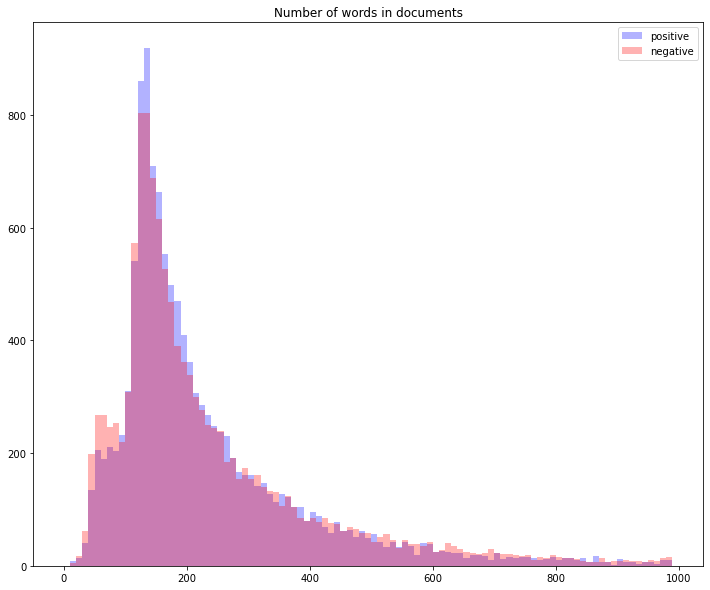

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
wordsInSeqs0=[len(s) for i,s in enumerate(x_train) if y_train[i]==0]
wordsInSeqs1=[len(s) for i,s in enumerate(x_train) if y_train[i]==1]
print("Documents in category tech: ",len(wordsInSeqs0))
print("Documents in category general: ",len(wordsInSeqs1))
plt.figure(figsize=(12,10))
plt.hist(wordsInSeqs0,bins=range(0,1000,10),color="blue",alpha=0.3,label="positive")
plt.hist(wordsInSeqs1,bins=range(0,1000,10),color="red",alpha=0.3,label="negative")
plt.legend()
plt.title("Number of words in documents")
plt.show()

### Padding

From the length-distribution above, we infer that a `MAX_SEQUENCE_LENGTH` of 600 may be appropriate.

In [13]:
MAX_SEQUENCE_LENGTH = 600  # all text-sequences are padded to this length

In [14]:
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH)

In [15]:
print("Training data shape: ",x_train.shape)
print("Test data shape: ",x_test.shape)

Training data shape:  (25000, 600)
Test data shape:  (25000, 600)


## Load Glove word-embeddings

Glove word embeddings can be downloaded from [https://nlp.stanford.edu/projects/glove/](https://nlp.stanford.edu/projects/glove/). In the following code-cell the variable `GLOVE_DIR` points to the directory, to which the downloaded embeddings has been extracted. The embeddings are loaded only if the `GLOVE`-parameter has been set to `True` before:

In [16]:
if GLOVE:
    import os
    from gensim.test.utils import datapath, get_tmpfile
    from gensim.models import KeyedVectors
    from gensim.scripts.glove2word2vec import glove2word2vec
    
    GLOVE_DIR = '/Users/johannes/DataSets/Gensim/glove/'
    glove_file = datapath(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
    tmp_file = get_tmpfile(os.path.join(GLOVE_DIR, 'test_word2vec.txt'))
    _ = glove2word2vec(glove_file, tmp_file)
    w2vmodel = KeyedVectors.load_word2vec_format(tmp_file)
    EMBEDDING_DIM=100
    print('Total %d word vectors in Glove 6B 100d.' % w2vmodel.vectors.shape[0])
    print('Length of word vectors in Glove 6B 100d: %d' % w2vmodel.vectors.shape[1])

Fasttext word embeddings can be downloaded from [https://fasttext.cc/docs/en/crawl-vectors.html](https://fasttext.cc/docs/en/crawl-vectors.html). In the following code-cell the directory, which is passed to `KeyedVectors.load_word2vec_format(directory)` is the directory, to which the downloaded embeddings has been extracted. The embeddings are loaded only if the `FASTTEXT`-parameter has been set to `True` before:

In [ ]:
if FASTTEXT:
    from gensim.models import KeyedVectors
    # Creating the model
    iMacPath="/Users/johannes/DataSets/nlp/wiki-news-300d-1M.vec"
    pathMacBook='/Users/maucher/DataSets/Gensim/FastText/fasttextEnglish300.vec'
    pathDeepLearn='../../DataSets/FastText/fasttextEnglish300.vec'
    w2vmodel = KeyedVectors.load_word2vec_format(iMacPath)
    EMBEDDING_DIM=w2vmodel.vector_size

As described above, if either `GLOVE` or `FASTTEXT` is `True`, then a pretrained word-embedding shall be applied in the Neural Networks, which are configured below. In this case an `embedding_matrix` must be prepared, which is applied in the `Embedding`-layer of the Neural Networks:

In [18]:
if USE_PRETRAINED:
    # prepare embedding matrix
    num_words = min(MAX_NB_WORDS, len(wordIndex))
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    count=0
    for (word, i) in wordIndexList[:MAX_NB_WORDS]:
        try:
            embedding_vector = w2vmodel[word]
            if embedding_vector is not None and i < MAX_NB_WORDS:
                embedding_matrix[i] = embedding_vector
        except:
            #print("{} not in wordembedding".format(word))
            count+=1
            continue

In [19]:
print("Number of word-embeddings with no vector in the given embedding:   ",count)

Number of word-embeddings with no vector in the given embedding:    1899


## CNN with only one layer

In the following code-cell the embedding layer is defined. This layer is then applied as first layer in the Neural Networks below. 
In row 
```
weights= [embedding_matrix] if USE_PRETRAINED else None,
```
the embedding-layer is defined such that a pretrained embedding_matrix is applied, if either `GLOVE` or `FASTTEXT` is `True`. Otherwise the embedding is learned from scratch in the document-classification task. In both cases the weights in this layer are learned, because `trainable` is set to be `True`.


In [20]:
embedding_layer = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
                            weights= [embedding_matrix] if USE_PRETRAINED else None,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

Next, the architecture of the CNN is defined. Note that the first layer in this architecture is the `embedding_layer`. 

The first network architecture consists of
* an embedding layer. This layer takes sequences of integers and learns word-embeddings. The sequences of word-embeddings are then passed to the first convolutional layer
* one 1D-convolutional layer, which applies filters of size 5 and learns 128 features in parallel
* one Max-Pooling layer to reduce the number of neurons, required in the following layers
* a MLP classifier with Dropout and one hidden layer and the output layer



In [21]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool3 = MaxPooling1D(5)(l_cov1) 
l_flat = Flatten()(l_pool3)
l_drop1 = Dropout(0.2)(l_flat)
l_dense = Dense(180, activation='relu')(l_drop1)
l_drop2 = Dropout(0.2)(l_dense)
preds = Dense(1, activation='sigmoid')(l_drop2)

model = Model(sequence_input, preds)

2022-03-09 11:58:24.163932: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Compile the model by defining training-parameters and display a summary of the architecture:

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer='ADAM',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 600, 300)          6000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 596, 128)          192128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 119, 128)          0         
_________________________________________________________________
flatten (Flatten)            (None, 15232)             0         
_________________________________________________________________
dropout (Dropout)            (None, 15232)             0         
_________________________________________________________________
dense (Dense)                (None, 180)               274194

Perform training:

In [23]:
print("model fitting - simplified convolutional neural network")

history=model.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=3, batch_size=128)

model fitting - simplified convolutional neural network


2022-03-09 11:59:00.838991: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
196/196 [==============================] - 135s 654ms/step - loss: 0.6791 - accuracy: 0.5542 - val_loss: 0.5599 - val_accuracy: 0.7532
Epoch 2/3
196/196 [==============================] - 107s 546ms/step - loss: 0.3329 - accuracy: 0.8582 - val_loss: 0.3613 - val_accuracy: 0.8416
Epoch 3/3
196/196 [==============================] - 102s 518ms/step - loss: 0.1256 - accuracy: 0.9546 - val_loss: 0.3730 - val_accuracy: 0.8583


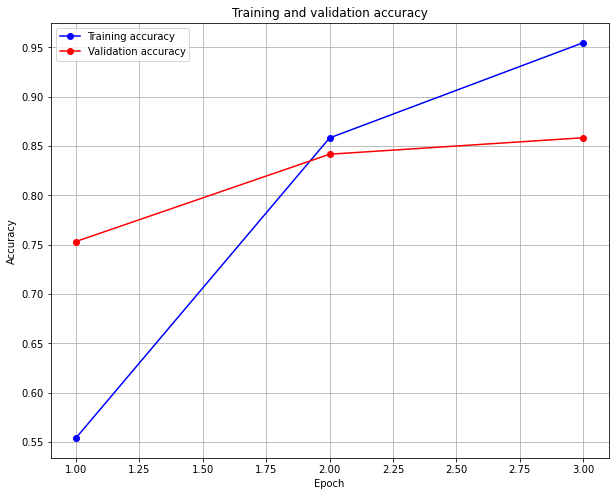

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
max_val_acc=np.max(val_acc)

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10,8))
plt.grid(True)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## CNN with 3 Convolutional Layers

In [25]:
embedding_layer = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
                            weights= [embedding_matrix] if USE_PRETRAINED else None,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [26]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(64, 3, activation='relu')(embedded_sequences)
l_cov2 = Conv1D(32, 3, activation='relu')(l_cov1)
l_cov3 = Conv1D(16, 3, activation='relu')(l_cov2)
l_flat = Flatten()(l_cov3)
l_drop1 = Dropout(0.2)(l_flat)
l_dense = Dense(180, activation='relu')(l_drop1)
l_drop2 = Dropout(0.2)(l_dense)
preds = Dense(1, activation='sigmoid')(l_drop2)

model = Model(sequence_input, preds)

In [27]:
model.compile(loss='binary_crossentropy',
              optimizer='ADAM',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 600)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 600, 300)          6000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 598, 64)           57664     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 596, 32)           6176      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 594, 16)           1552      
_________________________________________________________________
flatten_1 (Flatten)          (None, 9504)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9504)              0   

In [28]:
print("model fitting - simplified convolutional neural network")

history=model.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=3, batch_size=128)

model fitting - simplified convolutional neural network
Epoch 1/3
196/196 [==============================] - 70s 355ms/step - loss: 0.5969 - accuracy: 0.6272 - val_loss: 0.3360 - val_accuracy: 0.8541
Epoch 2/3
196/196 [==============================] - 71s 363ms/step - loss: 0.2385 - accuracy: 0.9023 - val_loss: 0.3179 - val_accuracy: 0.8673
Epoch 3/3
196/196 [==============================] - 75s 381ms/step - loss: 0.1143 - accuracy: 0.9593 - val_loss: 0.3780 - val_accuracy: 0.8630


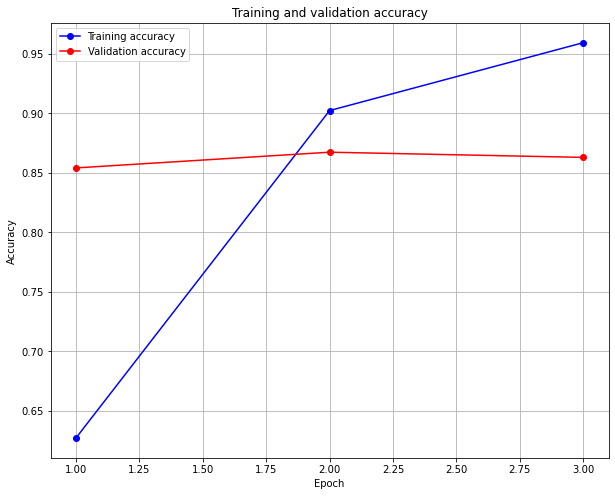

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
max_val_acc=np.max(val_acc)

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10,8))
plt.grid(True)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## CNN with different filter sizes in one layer
In [Y. Kim; Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1408.5882v2.pdf) a CNN with different filter-sizes in one layer has been proposed. This CNN is implemented below:

<img src="https://maucher.home.hdm-stuttgart.de/Pics/cnnSentenceClassification.PNG" alt="Drawing" style="width: 600px;"/>

Source: [Y. Kim; Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1408.5882v2.pdf)

In [30]:
embedding_layer = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
                            weights= [embedding_matrix] if USE_PRETRAINED else None,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [31]:
convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(filters=128,kernel_size=fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)
    
l_merge = Concatenate(axis=1)(convs)
l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(1, activation='sigmoid')(l_dense)

model = Model(sequence_input, preds)

In [32]:
model.compile(loss='binary_crossentropy',
              optimizer='ADAM',
              metrics=['accuracy'])

In [33]:
print("model fitting - more complex convolutional neural network")
model.summary()
history=model.fit(x_train, y_train, validation_data=(x_test, y_test),
          epochs=3, batch_size=128)

model fitting - more complex convolutional neural network
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 600)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 600, 300)     6000000     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 598, 128)     115328      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 597, 128)     153728      embedding_2[0][0]                
__________________________________

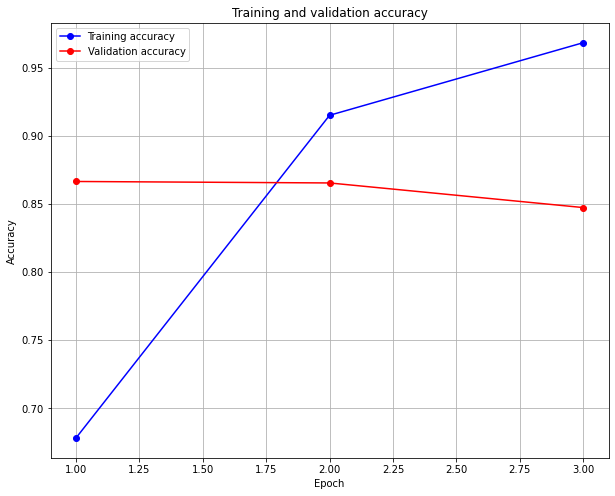

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
max_val_acc=np.max(val_acc)

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10,8))
plt.grid(True)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## LSTM text classification
### Define LSTM architecture

In [35]:
EMBEDDING_DIM=300
embedding_layer = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
                            #weights=[embedding_matrix], #if the weights-argument is not assigned, the word embedding is learned from the training-data
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
print("Number of words in each input: ",MAX_SEQUENCE_LENGTH)
# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(32)(embedded_sequences)
x = Dropout(0.3)(x)
preds = Dense(1,activation='sigmoid')(x)
model = Model(sequence_input, preds)
model.summary()

Number of words in each input:  600
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 600)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 600, 300)          6000000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                42624     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 6,042,657
Trainable params: 6,042,657
Non-trainable params: 0
_________________________________________________________________


### Training

In [36]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
history=model.fit(x_train, y_train,
          batch_size=128,
          epochs=3,   
          validation_data=(x_test, y_test))

Epoch 1/3
196/196 [==============================] - 116s 578ms/step - loss: 0.4860 - accuracy: 0.7675 - val_loss: 0.3659 - val_accuracy: 0.8451
Epoch 2/3
196/196 [==============================] - 109s 558ms/step - loss: 0.2565 - accuracy: 0.9038 - val_loss: 0.3720 - val_accuracy: 0.8486
Epoch 3/3
196/196 [==============================] - 108s 551ms/step - loss: 0.1596 - accuracy: 0.9456 - val_loss: 0.3613 - val_accuracy: 0.8533


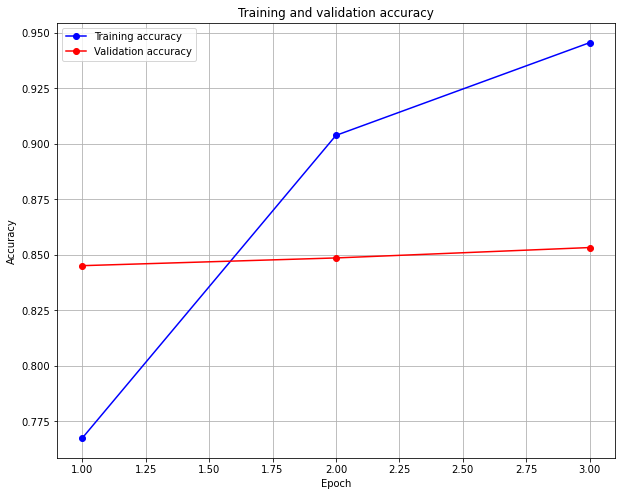

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
max_val_acc=np.max(val_acc)

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10,8))
plt.grid(True)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [39]:
print("Maximum accuracy: ",max_val_acc)

Maximum accuracy:  0.8532800078392029


**Result:**

In this task all the Neural Network architectures, which have implemented in this notebook, yield similar accuracy-values. However, in this notebook training has been limited to 3 epochs. Actually the networks should be trained longer. Moreover, no optimisation of hyperparameters (e.g. training-parameters) has been employed here.

## Appendix: Text Preprocessing with Keras

In the example of this notebook text access and preprocessing has been simple, because a corpus from keras in which texts are already presented in a format, which can directly be passed to the input of Keras Neural Networks. 

In real applications text corpora are usually provided as lists of strings. For example:

In [42]:
text = ["This is the first document",
              "The second document contains this text",
              "And here is a third document"]
text

['This is the first document',
 'The second document contains this text',
 'And here is a third document']

As shown above, we need to transform this list of strings into a list of integer-lists, where each integer-list is a sequence indices of the words in the corresponding text. 

This transformation can efficiently be implemented by the [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)-class of the `tensorflow.keras.preprocessing.text`-module as shown below:

In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
tokenizer.texts_to_sequences(text)

[[2, 3, 4, 5, 1], [4, 6, 1, 7, 2, 8], [9, 10, 3, 11, 12, 1]]

Below other useful attributes and methods, provided by the trained `Tokenizer`-class are demonstrated:

In [44]:
# print the attributes for the text and encode the doucment
print("\nTerm frequencies (How often do the individual terms occur in the corpus?):")
print(tokenizer.word_counts)
print("\nIn how much documents do the individual terms occur? :")
print(tokenizer.word_docs)
print("\nThe word index:")
print(tokenizer.word_index)
print("\nHow many documents are there?")
print(tokenizer.document_count)
print("\nBoW matrix:")
encoded_text = tokenizer.texts_to_matrix(text)
encoded_text


Term frequencies (How often do the individual terms occur in the corpus?):
OrderedDict([('this', 2), ('is', 2), ('the', 2), ('first', 1), ('document', 3), ('second', 1), ('contains', 1), ('text', 1), ('and', 1), ('here', 1), ('a', 1), ('third', 1)])

In how much documents do the individual terms occur? :
defaultdict(<class 'int'>, {'first': 1, 'the': 2, 'document': 3, 'is': 2, 'this': 2, 'second': 1, 'contains': 1, 'text': 1, 'and': 1, 'third': 1, 'here': 1, 'a': 1})

The word index:
{'document': 1, 'this': 2, 'is': 3, 'the': 4, 'first': 5, 'second': 6, 'contains': 7, 'text': 8, 'and': 9, 'here': 10, 'a': 11, 'third': 12}

How many documents are there?
3

BoW matrix:


array([[0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.]])